In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("s8a-dataframes-api").getOrCreate()
# Lectura de CSV con el ; como separador de columnas y con encabezado
df = spark.read.option("sep",";").option("header", "true").option("inferSchema", "true").csv("/FileStore/Notebook_3/pdi_sales_small.csv")
df.printSchema()

root
 |-- ProductID: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Zip: string (nullable = true)
 |-- Units: integer (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Country: string (nullable = true)



# Agregaciones

Una vez tenemos un DataFrame, podemos realizar analítica de datos sobre el dataset entero, o sobre una o más columnas y aplicar una función de agregación que permita sumar, contar o calcular la media de cualquier grupo, entre otras opciones. Para ello, PySpark ofrece un amplio [conjunto de funciones](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions). En nuestro caso, vamos a realizar algunos ejemplos para practicar con las funciones más empleadas.

## Contando

**[count](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.count.html)** : Devuelve la cantidad de elementos no nulos.

In [0]:
from pyspark.sql.functions import count
df.select(count("Country")).show()

+--------------+
|count(Country)|
+--------------+
|        120239|
+--------------+



**[count_distinct/countDistinct](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.count_distinct.html):** Devuelve la cantidad de elementos no nulos diferentes:  

In [0]:
from pyspark.sql.functions import count_distinct
df.select(count_distinct("Country"), count_distinct("Zip")).show()

+-----------------------+-------------------+
|count(DISTINCT Country)|count(DISTINCT Zip)|
+-----------------------+-------------------+
|                      5|               2585|
+-----------------------+-------------------+



**[approx_count_distinct / approxCountDistinct:](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.approx_count_distinct.html)** Devuelve aproximadamente la cantidad de elementos no nulos diferentes (puede recibir un segundo parámetro la máximo desviación estándar admitida). Este método es mucho más rápido que contar exactamente el número de resultado, y para datasets muy grandes, en ocasiones puede ser útil:

In [0]:
from pyspark.sql.functions import approx_count_distinct
df.select(approx_count_distinct("Country"), approx_count_distinct("Zip")).show()

+------------------------------+--------------------------+
|approx_count_distinct(Country)|approx_count_distinct(Zip)|
+------------------------------+--------------------------+
|                             5|                      2737|
+------------------------------+--------------------------+



## Calculando

**[min](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.min.html) y [max](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.max.html)**: permiten obtener el menor y el mayor valor respectivamente:

In [0]:
from pyspark.sql.functions import min, max
df.select(min("Units"), max("Units")).show()

+----------+----------+
|min(Units)|max(Units)|
+----------+----------+
|         1|        77|
+----------+----------+



[sum](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.sum.html) permite sumar todos los valores de una columna:

In [0]:
from pyspark.sql.functions import sum
df.select(sum("Units"), sum("Revenue")).show()

+----------+-------------------+
|sum(Units)|       sum(Revenue)|
+----------+-------------------+
|    125728|5.010727499998837E7|
+----------+-------------------+



**[sum_distinct / sumDistinct](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.sum_distinct.html)**: suma los valores diferentes de una columna:

In [0]:
from pyspark.sql.functions import sum_distinct
df.select(sum_distinct("Units"), sum_distinct("Revenue")).show()

+-------------------+---------------------+
|sum(DISTINCT Units)|sum(DISTINCT Revenue)|
+-------------------+---------------------+
|                308|    1189127.099999999|
+-------------------+---------------------+



**Asimetría, varianza y desviación estándar**: Si nos interesa obtener información estadística sobre los datos, también disponemos de las funciones `skewness`, `kurtosis`, `variance`, `var_pop`, `stddev` y `stddev_pop`.

> Actividad: Desarrolla ejemplos simples de como calcular con Pyspark las funciones `skewness`, `kurtosis`, `variance`, `var_pop`, `stddev` y `stddev_pop`. Explicar como se interpretan cada una de ellas.

## Agrupando  

Si agrupamos varias columnas de tipo categóricas (con una cardinalidad baja), podemos realizar cálculos sobre el resto de columnas.  

Sobre un DataFrame, podemos agrupar los datos por la columna que queramos utilizando el método[ groupBy](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html), el cual nos devuelve un [GroupedData](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.GroupedData.html#pyspark.sql.GroupedData), sobre el que posteriormente realizar operaciones como `avg(cols)`, `count()`, `mean(cols)`, `min(cols)`, `max(cols)` o `sum(cols)`:

**count**: 

In [0]:
from pyspark.sql.functions import sum
df.groupBy("Country").count().show()

+-------+-----+
|Country|count|
+-------+-----+
|Germany|30059|
|France |30059|
|Canada |30060|
|Mexico |30060|
| France|    1|
+-------+-----+



**sum**

In [0]:
df.groupBy("Country").sum("Revenue").show()

+-------+--------------------+
|Country|        sum(Revenue)|
+-------+--------------------+
|Germany|  1.49821199999994E7|
|France |1.2086961900000686E7|
|Canada |1.1642614200001836E7|
|Mexico |1.1394598700001087E7|
| France|               980.2|
+-------+--------------------+



Si necesitamos realizar más de un agregación sobre el mismo grupo, mediante [agg](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.GroupedData.agg.html) podemos indicar una o más expresiones de columnas:

In [0]:
from pyspark.sql.functions import sum, count
df.groupBy("Country").agg(sum("Revenue"), count("Revenue")).show()

+-------+--------------------+--------------+
|Country|        sum(Revenue)|count(Revenue)|
+-------+--------------------+--------------+
|Germany|  1.49821199999994E7|         30059|
|France |1.2086961900000686E7|         30059|
|Canada |1.1642614200001836E7|         30060|
|Mexico |1.1394598700001087E7|         30060|
| France|               980.2|             1|
+-------+--------------------+--------------+



También podemos indicar los elementos a calcular mediante un diccionario donde las claves son los campos y los valores la función a calcular:

In [0]:
df.groupBy("Country").agg({"Zip":"count", "Revenue":"avg"}).show()

+-------+----------+------------------+
|Country|count(Zip)|      avg(Revenue)|
+-------+----------+------------------+
|Germany|     30059| 498.4237665923484|
|France |     30059| 402.1079177617581|
|Canada |     30060|387.31251497012096|
|Mexico |     30060| 379.0618330007015|
| France|         1|             980.2|
+-------+----------+------------------+



## Agrupando colecciones

En ocasiones necesitamos agrupar en una colección todos los valores para un grupo en particular. Para ello, podemos usar [collect_list](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.collect_list.html) (con repetidos) o [collect_set](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.collect_set.html) (sin repeticiones):  

Por ejemplo, para cada país, vamos a recuperar un listado con los códigos postales de aquellos pedidos que hayan superado las 5 unidades:

In [0]:
from pyspark.sql.functions import collect_list, collect_set
df.where("Units > 5").groupBy("Country").agg(collect_list("Zip"), collect_set("Zip")).show()

+-------+--------------------+--------------------+
|Country|   collect_list(Zip)|    collect_set(Zip)|
+-------+--------------------+--------------------+
|Germany|[22397          ,...|[22111          ,...|
|France |[75213 CEDEX 16 ,...|[75391 CEDEX 08 ,...|
|Mexico |[7100           ,...|[10300          ,...|
|Canada |[T2X            ,...|[T6V            ,...|
+-------+--------------------+--------------------+



## Tablas pivote  
Las tablas pivote permiten obtener un resumen de los datos a partir de columnas categóricas sobre la que realizar cálculos, tal como se hace en las hojas de cálculo con las tablas dinámicas.  

Por ejemplo, vamos a obtener la cantidad recaudada por las ventas de cada año por cada país:

In [0]:
from pyspark.sql.functions import year

df.groupBy(year("Date").alias("Year")).pivot("Country").sum("Revenue").show()


+----+------------------+------+------------------+-----------------+------------------+
|Year|           Canada |France|           France |          Germany|           Mexico |
+----+------------------+------+------------------+-----------------+------------------+
|2003| 2360085.999999949|  null|1105230.9000000039|1407119.999999999|1049457.4999999995|
|2004| 1539140.499999946|  null|              null|             null|              null|
|2001| 2193437.799999908|  null|              null|             null|233419.20000000004|
|2000|1806678.3999999042|  null|1108846.8999999764|4510606.799999929| 4240448.399999948|
|1999|1382756.6999999755|  null| 7594921.200000447|5928459.100000297|3419368.2000001906|
|2002|2360514.7999998718| 980.2| 2277962.899999955|3135934.099999969| 2451905.399999923|
+----+------------------+------+------------------+-----------------+------------------+



También podemos hacer más de un cálculo sobre la tabla pivote:  


In [0]:
df.groupBy(year("Date")).pivot("Country").agg(sum("Revenue").alias("total"), sum("Units").alias("cantidad")).show()

+----------+------------------+----------------+------------+---------------+------------------+----------------+-----------------+----------------+------------------+----------------+
|year(Date)|     Canada _total|Canada _cantidad|France_total|France_cantidad|     France _total|France _cantidad|    Germany_total|Germany_cantidad|     Mexico _total|Mexico _cantidad|
+----------+------------------+----------------+------------+---------------+------------------+----------------+-----------------+----------------+------------------+----------------+
|      2003| 2360085.999999949|            6375|        null|           null|1105230.9000000039|            2794|1407119.999999999|            3099|1049457.4999999995|            2510|
|      2004| 1539140.499999946|            3636|        null|           null|              null|            null|             null|            null|              null|            null|
|      2001| 2193437.799999908|            5976|        null|           nul

## Joins

Hasta ahora todo la analítica la hemos realizado sobre un único DataFrame. Aunque si seguimos un proceso ELT es probable que tengamos todos los datos en un único lugar, en ocasiones necesitamos cruzar la información de dos datasets.

Si nos basamos en el planteamiento de una base de datos relacional, para unir dos DataFrames necesitamos unir la clave ajena de uno con la clave primaria del otro.

Para estos ejemplos, vamos a cambiar de datasets y utilizar datos de vuelos de avión que han tenido algún tipo de retraso ([departure_delays.csv](https://tajamar365.sharepoint.com/:x:/s/3405-MasterIA2024-2025/EVXFsnm7tWdIv7hohU6UsRgBIdV_ghMxvtUxSyduUcxYow?e=n85sNv)) y otro con los códigos de los aeropuertos ([airport-codes-na.tsv](https://tajamar365.sharepoint.com/:u:/s/3405-MasterIA2024-2025/EePe905sgTZOnSMvFE9DpV4BLHICLNcb9VTIYEU7svCOcw?e=AxFwQE)).

**Vuelos con retraso**  
Fichero CSV con la coma como separador de campos.   
```<csv> 
date,delay,distance,origin,destination
01011245,6,602,ABE,ATL
01020600,-8,369,ABE,DTW
01021245,-2,602,ABE,ATL
01020605,-4,602,ABE,ATL
```

**Códigos de aeropuertos**  

Fichero TSV con el tabulador como separador campos, donde el campo `IATA` es la clave de cada aeropuerto.  
```<tsv>
City State Country IATA
Abbotsford BC Canada YXX
Aberdeen SD USA ABR
Abilene TX USA ABI
Akron OH USA CAK
Alamosa CO USA ALS
Albany GA USA ABY
```

Así pues, lo primero que vamos a hacer es cargar ambos DataFrames:

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("s8a-dataframes-joins").getOrCreate()

df_vuelos = spark.read.option("sep",",").option("header", "true").option("inferSchema", "true").csv("/FileStore/Notebook_3/departure_delays.csv")
# df_vuelos.printSchema()
# df_vuelos.count()   # 1391578
df_aeropuertos = spark.read.option("sep","\t").option("header", "true").option("inferSchema", "true").csv("/FileStore/Notebook_3/airport_codes_na.tsv")
# df_aeropuertos.printSchema()

### Mediante SQL  
Si queremos hacer un join mediante SQL, sólo tenemos que emplear la misma sintaxis que con cualquier sistema relacional, de manera que primero crearemos las vistas temporales:

In [0]:
df_vuelos.createOrReplaceTempView("vuelos")
df_aeropuertos.createOrReplaceTempView("aeropuertos")


Y a continuación realizamos la consulta:

In [0]:
df_join = spark.sql("select v.origin, a.city from vuelos v join aeropuertos a on v.origin == a.IATA")
df_join.show(3)

+------+---------+
|origin|     city|
+------+---------+
|   ABE|Allentown|
|   ABE|Allentown|
|   ABE|Allentown|
+------+---------+
only showing top 3 rows



Si quisiéramos obtener el nombre de los dos aeropuertos, necesitamos realizar dos veces el join:

In [0]:
df_join = spark.sql("select v.*, a.City as originCity, b.City as destinationCity from vuelos v JOIN aeropuertos a on v.origin == a.IATA join aeropuertos b on v.destination = b.IATA")
df_join.show(3)

# +-------+-----+--------+------+-----------+----------+---------------+
# |   date|delay|distance|origin|destination|originCity|destinationCity|
# +-------+-----+--------+------+-----------+----------+---------------+
# |1011245|    6|     602|   ABE|        ATL| Allentown|        Atlanta|
# |1020600|   -8|     369|   ABE|        DTW| Allentown|        Detroit|
# |1021245|   -2|     602|   ABE|        ATL| Allentown|        Atlanta|
# +-------+-----+--------+------+-----------+----------+---------------+
# only showing top 3 rows

+-------+-----+--------+------+-----------+----------+---------------+
|   date|delay|distance|origin|destination|originCity|destinationCity|
+-------+-----+--------+------+-----------+----------+---------------+
|1011245|    6|     602|   ABE|        ATL| Allentown|        Atlanta|
|1020600|   -8|     369|   ABE|        DTW| Allentown|        Detroit|
|1021245|   -2|     602|   ABE|        ATL| Allentown|        Atlanta|
+-------+-----+--------+------+-----------+----------+---------------+
only showing top 3 rows



Si existiera algún vuelo cuyos códigos de aeropuerto no tuviéramos disponible en el dataset de los códigos de aeropuertos, no nos aparecería. Por tanto, sería más conveniente realizar un left join:

In [0]:
df_left_join = spark.sql("select v.*, a.City as originCity, b.City as destinationCity from vuelos v LEFT JOIN aeropuertos a on v.origin == a.IATA LEFT JOIN aeropuertos b on v.destination = b.IATA")
df_left_join.show(3)


+-------+-----+--------+------+-----------+----------+---------------+
|   date|delay|distance|origin|destination|originCity|destinationCity|
+-------+-----+--------+------+-----------+----------+---------------+
|1011245|    6|     602|   ABE|        ATL| Allentown|        Atlanta|
|1020600|   -8|     369|   ABE|        DTW| Allentown|        Detroit|
|1021245|   -2|     602|   ABE|        ATL| Allentown|        Atlanta|
+-------+-----+--------+------+-----------+----------+---------------+
only showing top 3 rows



In [0]:
df_left_join.count()    # 1391578

Out[115]: 1391578

> **Todo tipo de joins**  
 Además de los casos vistos, podemos realizar otros tipos de joins como `cross`, `semi`, `full`, `outer`, etc... Más información en la [documentación oficial](https://spark.apache.org/docs/latest/sql-ref-syntax-qry-select-join.html)

Un caso particular que conviene conocer es el left anti join. Este tipo de join permite obtener aquellos registros de la izquierda que no aparecen en la parte derecha, de manera que si seguimos con el ejemplo, podemos recuperar aquellos vuelos cuyos aeropuertos no tenemos en el dataset con los códigos:

In [0]:
df_left_anti_join = spark.sql("select * from vuelos v LEFT ANTI JOIN aeropuertos a ON v.origin == a.IATA ")
df_left_anti_join.count()   # 14416

Out[116]: 14416

### Mediante Python  

Si no queremos utilizar SQL o ya tenemos fragmentos de código que interactúan con el DataFrame API, podemos utilizar el método `join`. Este método une dos DataFrames, indicando la expresión de unión y opcionalmente el tipo:

In [0]:
exprJoin1 = df_vuelos.origin == df_aeropuertos.IATA
df_joinp1 = df_vuelos.join(df_aeropuertos, exprJoin1, "inner")


In [0]:
df_joinp1.count()    # 1377162

Out[118]: 1377162

> **Forma corta**. Si las columnas que unen los DataFrames tienen el mismo nombre, podemos simplificar el código indicando únicamente su nombre:  
`df1.join(df2, "user_id")`  
Además, si queremos hacer un inner join, podemos no indicarlo ya que es el tipo por defecto.

En vez de pasarle `inner`, le podemos indicar el tipo de join: `left`, `right`, `cross`, `left_anti`, etc...

In [0]:
expr_join1 = df_vuelos.origin == df_aeropuertos.IATA
df_left_anti_join = df_vuelos.join(df_aeropuertos, expr_join1, "left_anti")
df_left_anti_join.count()   # 14416

Out[119]: 14416

Finalmente, como en nuestro caso teníamos dos joins, tanto para los vuelos de origen como los de destino, necesitamos volver a unir:

In [0]:
from pyspark.sql.functions import col
# le indicamos alias a los campos para eliminar ambigüedades
expr_join2 = col("a.destination") == col("b.IATA")
df_joinp2 = (df_joinp1.alias("a")).join((df_aeropuertos.alias("b")), expr_join2, "inner")
df_joinp2.count()    # 1361141

Out[120]: 1361141

## Funciones  
Para dominar realmente Spark, hay que tener destreza en todas las funciones existentes para el tratamiento de fechas, cadenas, operaciones matemáticas, para trabajar con colecciones, etc...

Además, siempre podemos crear nuestras propias funciones de usuario para ampliar el lenguaje.

Aunque ya hemos utilizado algunas a lo largo de los apuntes, a continuación vamos a repasar las funciones más empleadas.

### Fechas  
- Si necesitamos convertir de texto a fecha: [to_date](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.to_date.html), [to_timestamp](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.to_timestamp.html), [unix_timestamp](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.unix_timestamp.html)  
- Para formatear las fechas: [date_format](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.date_format.html), [from_unixtime](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.from_unixtime.html) ([patrones de fechas](https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html))  
- Para realizar cálculos sobre fechas: `datediff`, `months_between`, `last_day`, `date_add`, `date_sub`, `next_day`.  
- Extraer un valor de una fecha:[ year](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.year.html), [month](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.month.html), [weekofyear](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.weekofyear.html), [dayofmonth](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.dayofmonth.html), [dayofyear](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.dayofyear.html), [hour](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.hour.html),[ minute](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.minute.html), [second](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.second.html).    

Más información en la [documentación oficial](https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#date-and-timestamp-functions)


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

spark = SparkSession.builder.appName("s8a-dataframes-sql").getOrCreate()

df = spark.read.option("sep",";").option("header", "true").option("inferSchema", "true").csv("/FileStore/Notebook_3/pdi_sales_small.csv")
# Cambiamos el tipo de dato a fecha
df = df.withColumn("Date", to_date(df.Date, "M/d/yyy"))

In [0]:
from pyspark.sql.functions import date_format, next_day, last_day, dayofmonth, dayofyear, month, year

df.select(
    "Date",
    date_format("Date", "dd-MM-yyyy").alias("Formatted_Date"),
    next_day("Date", "Sun").alias("Next_Sunday"),
    last_day("Date").alias("Last_Day_of_Month"),
    dayofmonth("Date").alias("Day_of_Month"),
    dayofyear("Date").alias("Day_of_Year"),
    month("Date").alias("Month"),
    year("Date").alias("Year")
).show(2)


+----------+--------------+-----------+-----------------+------------+-----------+-----+----+
|      Date|Formatted_Date|Next_Sunday|Last_Day_of_Month|Day_of_Month|Day_of_Year|Month|Year|
+----------+--------------+-----------+-----------------+------------+-----------+-----+----+
|1999-01-15|    15-01-1999| 1999-01-17|       1999-01-31|          15|         15|    1|1999|
|2002-06-06|    06-06-2002| 2002-06-09|       2002-06-30|           6|        157|    6|2002|
+----------+--------------+-----------+-----------------+------------+-----------+-----+----+
only showing top 2 rows



### Cadenas  
Por ejemplo, tenemos las funciones para quitar espacios ([`ltrim`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.ltrim.html), [`rtrim`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.rtrim.html), [`trim`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.trim.html)) y pasar a mayúsculas/minúsculas ([`lower`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.lower.html), [`upper`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.upper.html)):

In [0]:
from pyspark.sql.functions import ltrim, rtrim, trim, lower, upper

df.select(
    "Zip",
    ltrim("Zip").alias("l"),  # Elimina espacios en blanco a la izquierda
    rtrim("Zip").alias("r"),  # Elimina espacios en blanco a la derecha
    lower("Zip").alias("lower(Zip)"),  # Convierte a minúsculas
    upper("Zip").alias("upper(Zip)")   # Convierte a mayúsculas
).where(
    trim(df.Country) == "Canada"  # Elimina espacios en blanco de ambos lados antes de comparar
).show(3)


+---------------+---------------+---+---------------+---------------+
|            Zip|              l|  r|     lower(Zip)|     upper(Zip)|
+---------------+---------------+---+---------------+---------------+
|H1B            |H1B            |H1B|h1b            |H1B            |
|H1B            |H1B            |H1B|h1b            |H1B            |
|H1B            |H1B            |H1B|h1b            |H1B            |
+---------------+---------------+---+---------------+---------------+
only showing top 3 rows



O funciones para poner la inicial en mayúsculas ([initcap](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.initcap.html)), darle la vuelta ([reverse](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.reverse.html)), obtener su tamaño ([length](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.length.html)) o reemplazar caracteres ([translate](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.translate.html)):

In [0]:
from pyspark.sql.functions import initcap, reverse, length, translate, trim

df.select(
    "Country",
    initcap("Country").alias("Initcap(Country)"),  # Convierte a formato título (primera letra en mayúscula)
    reverse("Country").alias("Reverse(Country)"),  # Invierte la cadena
    length("Country").alias("Length(Country)"),    # Longitud de la cadena
    translate("Country", "na", "pe").alias("Translate(Country)")  # Reemplaza 'n' con 'p' y 'a' con 'e'
).where(
    trim(df.Country) == "Canada"  # Elimina espacios en blanco antes de comparar
).show(1)


+-------+----------------+----------------+---------------+------------------+
|Country|Initcap(Country)|Reverse(Country)|Length(Country)|Translate(Country)|
+-------+----------------+----------------+---------------+------------------+
|Canada |         Canada |          adanaC|              7|           Cepede |
+-------+----------------+----------------+---------------+------------------+
only showing top 1 row



También podemos trabajar con subcadenas ([substring](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.substring.html)), encontrar ocurrencias ([locate](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.locate.html)) o partir una cadena en trozos ([split](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html)):

In [0]:
from pyspark.sql.functions import split, locate, substring, trim

df.select(
    "Country",
    split("Country", "a").alias("Split(Country, 'a')"),  # Divide la cadena por el carácter 'a'
    locate("a", "Country").alias("Locate('a', Country)"),  # Encuentra la posición de la primera aparición de 'a'
    substring("Country", 3, 2).alias("Substring(Country, 3, 2)")  # Extrae dos caracteres a partir de la posición 3
).where(
    trim(df.Country) == "Canada"  # Elimina espacios en blanco antes de comparar
).show(1)


+-------+-------------------+--------------------+------------------------+
|Country|Split(Country, 'a')|Locate('a', Country)|Substring(Country, 3, 2)|
+-------+-------------------+--------------------+------------------------+
|Canada |       [C, n, d,  ]|                   2|                      na|
+-------+-------------------+--------------------+------------------------+
only showing top 1 row



Otras funciones que se suelen utilizar son [concat](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.concat.html) y [concat_ws](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.concat.html) para unir cadenas, [levenshtein](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.levenshtein.html) para calcular la distancia entre dos cadenas, [lpad](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.lpad.html) y [rpad](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.rpad.html) para completar con espacios, etc... Si necesitas trabajar con expresiones regulares puedes utilizar [regexp_extract](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.regexp_extract.html) para extraer parte de una cadena como [regexp_replace](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.regexp_replace.html) para sustituir.

### Colecciones  
Para probar las funciones que trabajan con colecciones, vamos a cambiar de dataset y trabajar con uno compartido por [Kaggle](https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset) con datos de negocios de Yelp que tenemos almacenados en una versión reducida en [yelp_academic_dataset_business.json](https://tajamar365.sharepoint.com/:u:/s/3405-MasterIA2024-2025/ERoGHfFcPLhNn_YpkErPJ1oB0k9319KZG7ds-_yuklBJAg?e=ToWz1U). Los negocios tienen una propiedad denominada `categories` que contiene un array con las categorías de los mismos:

```<JSON>
{
   "business_id":"O_X3PGhk3Y5JWVi866qlJg",
   "full_address":"1501 W Bell Rd\nPhoenix, AZ 85023",
   "hours":{
      "Monday":{
         "close":"18:00",
         "open":"11:00"
      },
      "Tuesday":{
         "close":"18:00",
         "open":"11:00"
      },
        ...
   },
   "open":true,
   "categories":[
      "Active Life",
      "Arts & Entertainment",
      "Stadiums & Arenas",
      "Horse Racing"
   ],
   "city":"Phoenix",
   ...
}
```

El primer paso es cargar el documento y ver el esquema inferido por Spark:

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("s8a-dataframes-arrays").getOrCreate()

df = spark.read.option("inferSchema", "true").option("multiline",True).json("/FileStore/Notebook_3/yelp_academic_dataset_business.json")

df.printSchema()

root
 |-- attributes: struct (nullable = true)
 |    |-- Accepts Credit Cards: boolean (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: struct (nullable = true)
 |    |    |-- casual: boolean (nullable = true)
 |    |    |-- classy: boolean (nullable = true)
 |    |    |-- divey: boolean (nullable = true)
 |    |    |-- hipster: boolean (nullable = true)
 |    |    |-- intimate: boolean (nullable = true)
 |    |    |-- romantic: boolean (nullable = true)
 |    |    |-- touristy: boolean (nullable = true)
 |    |    |-- trendy: boolean (nullable = true)
 |    |    |-- upscale: boolean (nullable = true)
 |    |-- Attire: string (nullable = true)
 |    |-- Delivery: boolean (nullable = true)
 |    |-- Good For: struct (nullable = true)
 |    |    |-- breakfast: boolean (nullable = true)
 |    |    |-- brunch: boolean (nullable = true)
 |    |    |-- dessert: boolean (nullable = true)
 |    |    |-- dinner: boolean (nullable = true)
 |    |    |-- latenight

Como se puede observar, sigue una estructura de elementos anidados.

Por ejemplo, vamos a ver mediante un ejemplo las siguientes funciones:  
- `size`: devuelve el tamaño de la colección  
- `sort_array`: ordena la colección  
- `array_contains`: comprueba si hay un elemento en la colección

In [0]:
df.select("hours").show(truncate=False)


+----------------------------------------------------------------------------------------------------------------+
|hours                                                                                                           |
+----------------------------------------------------------------------------------------------------------------+
|{{18:00, 11:00}, {18:00, 11:00}, {18:00, 11:00}, {18:00, 11:00}, {18:00, 11:00}, {18:00, 11:00}, {18:00, 11:00}}|
+----------------------------------------------------------------------------------------------------------------+



In [0]:
df = df.filter(df["hours"].isNotNull())


In [0]:
from pyspark.sql.functions import size, sort_array, array_contains

df.select(
    "name",
    "hours.Sunday",
    size("categories").alias("totalCategories"),  # Cuenta el número de elementos en la lista 'categories'
    sort_array("categories").alias("sortedCategories"),  # Ordena los elementos de 'categories'
    array_contains("categories", "Restaurants").alias("isRestaurant")  # Verifica si 'categories' contiene "Restaurants"
).show(10, truncate=False)


+-------------------------+--------------+---------------+--------------------------------------------------------------------+------------+
|name                     |Sunday        |totalCategories|sortedCategories                                                    |isRestaurant|
+-------------------------+--------------+---------------+--------------------------------------------------------------------+------------+
|Turf Paradise Race Course|{18:00, 11:00}|4              |[Active Life, Arts & Entertainment, Horse Racing, Stadiums & Arenas]|false       |
+-------------------------+--------------+---------------+--------------------------------------------------------------------+------------+



Así pues, además del nombre, hemos obtenido el horario de los domingos utilizando la notación `.` para acceder a los campos anidados, la cantidad de categorías de cada comercio, un listado ordenado con sus categorías y finalmente si es un restaurante.

> **Tip**  
> Recuerda que en el apartado `Agrupando colecciones` vimos como podemos crear colecciones al realizar una agrupación.

Otro tipo de operación que podemos realizar es desenrollar una colección mediante la función `explode` y generar una fila nueva por cada elemento de la colección:

In [0]:
df.select("name", explode("categories")).show(10, truncate=False)
# +-------------------------+--------------------+
# |name                     |col                 |
# +-------------------------+--------------------+
# |Turf Paradise Race Course|Active Life         |
# |Turf Paradise Race Course|Arts & Entertainment|
# |Turf Paradise Race Course|Stadiums & Arenas   |
# |Turf Paradise Race Course|Horse Racing        |
# |Sam's Club Members Only  |Tires               |
# |Sam's Club Members Only  |Automotive          |
# |Sam's Club Members Only  |Fashion             |
# |Sam's Club Members Only  |Shopping            |
# |Sam's Club Members Only  |Department Stores   |
# |Forever 21               |Women's Clothing    |
# +-------------------------+--------------------+
# only showing top 10 rows

+-------------------------+--------------------+
|name                     |col                 |
+-------------------------+--------------------+
|Turf Paradise Race Course|Active Life         |
|Turf Paradise Race Course|Arts & Entertainment|
|Turf Paradise Race Course|Stadiums & Arenas   |
|Turf Paradise Race Course|Horse Racing        |
+-------------------------+--------------------+



### JSON  

Es común que se de el caso de que los datos que leemos desde un sistema externo estén en formato JSON pero que el proceso de ingesta lo haya realizado como si fuera una cadena de texto.

Supongamos que tenemos la siguiente cadena y generados un DataFrame a partir de un RDD:

In [0]:
tareas = ["""{"dia": "Lunes", "tareas": ["Corregir ejercicios", "Ir a nadar", "Comprar pan"]}"""]
# ['{"dia": "Lunes", "tareas": ["Corregir ejercicios", "Ir a nadar", "Comprar pan"]}']
tareasRDD = spark.sparkContext.parallelize(tareas)
tareasStrDF = tareasRDD.toDF("string")
# tareasStrDF es un DF con una columna con nombre value de tipo string



In [0]:
tareasStrDF.printSchema()
# root
#  |-- value: string (nullable = true)

root
 |-- value: string (nullable = true)



In [0]:
tareasStrDF.show()
# +--------------------+
# |               value|
# +--------------------+
# |{"dia": "Lunes", ...|
# +--------------------+

+--------------------+
|               value|
+--------------------+
|{"dia": "Lunes", ...|
+--------------------+



Para pasarlo a JSON, necesitamos definir un esquema con la estructura del documento JSON:  

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, ArrayType

esquemaTareas = StructType([
    StructField("dia", StringType(), False),
    StructField("tareas", ArrayType(StringType(), False), False)
])

Y a continuación ya podemos transformar el formato mediante la función [`from_json`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.from_json.html):

In [0]:
todosDF = tareasStrDF.select(from_json("value", esquemaTareas).alias("datos"))
todosDF.printSchema()
# root
#  |-- datos: struct (nullable = true)
#  |    |-- dia: string (nullable = true)
#  |    |-- tareas: array (nullable = true)
#  |    |    |-- element: string (containsNull = true)

root
 |-- datos: struct (nullable = true)
 |    |-- dia: string (nullable = true)
 |    |-- tareas: array (nullable = true)
 |    |    |-- element: string (containsNull = true)



Y ahora ya podemos acceder a los datos (en el siguiente ejemplo empleamos la función `getItem` para acceder a un elemento de una columna, así como la notación punto mediante una expresión y los corchetes para recuperar un determinado elemento):

In [0]:
todosDF.select(
    col("datos").getItem("dia").alias("datos.dia"),  # Extrae el campo 'dia'
    col("datos").getItem("tareas").alias("tareas"),  # Extrae el campo 'tareas' completo
    col("datos").getItem("tareas")[0].alias("tarea1")  # Accede al primer elemento de 'tareas'
).show(truncate=False)


+---------+----------------------------------------------+-------------------+
|datos.dia|tareas                                        |tarea1             |
+---------+----------------------------------------------+-------------------+
|Lunes    |[Corregir ejercicios, Ir a nadar, Comprar pan]|Corregir ejercicios|
+---------+----------------------------------------------+-------------------+



Para terminar, si necesitamos la operación inversa, y lo que queremos es crear una representación JSON de una columna, podemos utilizar la función [to_json](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.to_json.html):

In [0]:
todosDF.select(to_json("datos")).show(truncate=False)
# +---------------------------------------------------------------------------+
# |to_json(datos)                                                             |
# +---------------------------------------------------------------------------+
# |{"dia":"Lunes","tareas":["Corregir ejercicios","Ir a nadar","Comprar pan"]}|
# +---------------------------------------------------------------------------+

+---------------------------------------------------------------------------+
|to_json(datos)                                                             |
+---------------------------------------------------------------------------+
|{"dia":"Lunes","tareas":["Corregir ejercicios","Ir a nadar","Comprar pan"]}|
+---------------------------------------------------------------------------+



### UDF  
Además de las funciones que ofrece Spark, en cualquier momento podemos crear nuestras funciones de usuario (User-Defined Functions) para ampliar la expresividad de Spark. Antes de utilizarlas, las hemos de definir y registrar.

Si volvemos al dataset de ventas, teníamos la siguiente información:

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("s8a-dataframes-api").getOrCreate()
# Lectura de CSV con el ; como separador de columnas y con encabezado
df = spark.read.option("sep",";").option("header", "true").option("inferSchema", "true").csv("/FileStore/Notebook_3/pdi_sales_small.csv")
df.printSchema()

root
 |-- ProductID: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Zip: string (nullable = true)
 |-- Units: integer (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Country: string (nullable = true)



In [0]:
df.select("ProductID", "Revenue", "Units").sort("Units", ascending=False).show(5)
# +---------+-------+-----+
# |ProductID|Revenue|Units|
# +---------+-------+-----+
# |      495|43194.1|   77|
# |     2091| 6347.7|   41|
# |     2091| 6240.1|   41|
# |     2091| 3652.7|   24|
# |     2091| 3560.9|   23|
# +---------+-------+-----+
# only showing top 5 rows

+---------+-------+-----+
|ProductID|Revenue|Units|
+---------+-------+-----+
|      495|43194.1|   77|
|     2091| 6347.7|   41|
|     2091| 6240.1|   41|
|     2091| 3652.7|   24|
|     2091| 3560.9|   23|
+---------+-------+-----+
only showing top 5 rows



Vamos a crear una función para que, si vende más de una unidad, se le asigne a cada producto un bonus de un 1%. Para ello, primero definiremos la función mediante Python, y posteriormente, la registraremos mediante la función [udf](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.udf.html):

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def bonus(unidades, ventas):
    if unidades == 1 :
        return 0.0
    else:
        return unidades * ventas / 100

udfBonus = udf(bonus, DoubleType())

Así pues, si realizamos una consulta, ya podemos utilizar la función recién creada como si fuera una propia de Spark:

In [0]:
df.select("ProductID", "Revenue", "Units", udfBonus(df.Units, df.Revenue)).sort("Units", ascending=False).show(5)
# +---------+-------+-----+---------------------+
# |ProductID|Revenue|Units|bonus(Units, Revenue)|
# +---------+-------+-----+---------------------+
# |      495|43194.1|   77|   33259.456999999995|
# |     2091| 6347.7|   41|             2602.557|
# |     2091| 6240.1|   41|   2558.4410000000003|
# |     2091| 3652.7|   24|    876.6479999999999|
# |     2091| 3560.9|   23|              819.007|
# +---------+-------+-----+---------------------+
# only showing top 5 rows

+---------+-------+-----+---------------------+
|ProductID|Revenue|Units|bonus(Units, Revenue)|
+---------+-------+-----+---------------------+
|      495|43194.1|   77|   33259.456999999995|
|     2091| 6347.7|   41|             2602.557|
|     2091| 6240.1|   41|   2558.4410000000003|
|     2091| 3652.7|   24|    876.6479999999999|
|     2091| 3560.9|   23|              819.007|
+---------+-------+-----+---------------------+
only showing top 5 rows



Si queremos definir la función para poder utilizarla dentro de Spark SQL y obtener el mismo resultado, hemos de registrar la función mediante *spark.udf.register*, la cual recibe el nombre que le asignaremos a la función, el nombre de la función Python a invocar, y el tipo de dato que devuelve:

In [0]:
# Registra la función UDF
spark.udf.register("udfBonus", bonus, DoubleType())

# Registra el DataFrame como una vista temporal
df.createOrReplaceTempView("ventas")

# Ejecuta la consulta SQL
spark.sql(
    """
    SELECT ProductID, Revenue, Units, 
           udfBonus(Units, Revenue) AS Bonus
    FROM ventas
    ORDER BY Units DESC
    """
).show(5)


+---------+-------+-----+------------------+
|ProductID|Revenue|Units|             Bonus|
+---------+-------+-----+------------------+
|      495|43194.1|   77|33259.456999999995|
|     2091| 6347.7|   41|          2602.557|
|     2091| 6240.1|   41|2558.4410000000003|
|     2091| 3652.7|   24| 876.6479999999999|
|     2091| 3560.9|   23|           819.007|
+---------+-------+-----+------------------+
only showing top 5 rows



> **UDF y Python**  
> En un principio, se desaconseja la creación de UDF mediante Python, ya que su uso penaliza de forma significativa el rendimiento. Los ejecutores son procesos en máquinas virtuales de Java que están escritos en Java, y por ello, ejecutan código Java o Scala de forma nativa. En cambio, para Python tiene que ejecutar un proceso separado para ejecutar la UDF, lo que implica un coste extra para serializar y volver a deserializar los datos para cada fila del dataset.  

### Cacheando  

Un DataFrame se puede persistir/cachear en memoria conforme necesitemos (también lo podemos hacer con los RDD). Su principal propósito es cuando vamos a acceder a un DataFrame una y otra vez y no necesitamos que se vuelvan a evaluar todas las operaciones (como pueden ser los algoritmos iterativos utilizados en Machine Learning).

> Si estás interesado en optimizar el uso de memoria al trabajar con DataFrames, [Brayan Buitrago](https://brabuitrago.medium.com/) tiene una serie de artículos sobre [Spark Performace: Cache() & Persist()](https://medium.com/iwannabedatadriven/spark-performace-cache-persist-i-c39e0c142fe5) muy interesantes.

Cuando persistimos un dataset, cada nodo almacena sus datos particionados en memoria y/o disco y los reutiliza en otras operaciones sobre dicho dataset.  
Para ello, se emplean los métodos [cache](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.cache.html) / [persist](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.persist.html) y [unpersist](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.unpersist.html) para cachear y liberar los datos.

In [0]:
df.persist()
df.count()  # forzamos la evaluación perezosa

Out[152]: 120239

In [0]:
# Filtrar para ventas en Canadá
ventasCanada = df.filter(df["Country"] == "Canada")


In [0]:
spark.catalog.cacheTable("ventasCanada")


In [0]:
spark.sql("SELECT * FROM ventasCanada").show()


+---------+----+---+-----+-------+-------+
|ProductID|Date|Zip|Units|Revenue|Country|
+---------+----+---+-----+-------+-------+
+---------+----+---+-----+-------+-------+



Una vez persistidos los datos, si accedemos a http://localhost:4040 (si se usa Docker + Jupyter Lab) veremos en la pestaña Storage que se ha creado la tabla, su tipo de almacenamiento y particiones cacheadas. **Si estás en Databricks** has click en `Compute`, luego en `Spark UI` y despues click en `Storage`, deberias ver esto:

![](https://community.cloud.databricks.com/files/Notebook_3/1.png)

Una diferencia fundamental a la hora de persistir un DataFrame en comparación con un RDD, es que como Spark SQL conoce el esquema de los datos en el DataFrame, puede organizarlos de forma columnar y aplicar compresión sobre éstos para minimizar el espacio necesario.

## DataFrames y Pandas

En cualquier momento podemos pasar los datos de un DataFrame de PySpark a uno de Pandas para poder aprovechar su API.

Si seguimos con el dataset de Yelp, vamos a preparar una consulta de nos devuelva la cantidad de votos recibidos y puntuación media de cada ciudad:

In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("s8a-dataframes-arrays").getOrCreate()

df = spark.read.option("inferSchema", "true").option("multiline",True).json("/FileStore/Notebook_3/yelp_academic_dataset_business.json")

df.printSchema()

root
 |-- attributes: struct (nullable = true)
 |    |-- Accepts Credit Cards: boolean (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: struct (nullable = true)
 |    |    |-- casual: boolean (nullable = true)
 |    |    |-- classy: boolean (nullable = true)
 |    |    |-- divey: boolean (nullable = true)
 |    |    |-- hipster: boolean (nullable = true)
 |    |    |-- intimate: boolean (nullable = true)
 |    |    |-- romantic: boolean (nullable = true)
 |    |    |-- touristy: boolean (nullable = true)
 |    |    |-- trendy: boolean (nullable = true)
 |    |    |-- upscale: boolean (nullable = true)
 |    |-- Attire: string (nullable = true)
 |    |-- Delivery: boolean (nullable = true)
 |    |-- Good For: struct (nullable = true)
 |    |    |-- breakfast: boolean (nullable = true)
 |    |    |-- brunch: boolean (nullable = true)
 |    |    |-- dessert: boolean (nullable = true)
 |    |    |-- dinner: boolean (nullable = true)
 |    |    |-- latenight

In [0]:
df.select("city").distinct().show()


+-------+
|   city|
+-------+
|Phoenix|
+-------+



In [0]:
from pyspark.sql.functions import count, avg, round
dfVotosCiudades = df.groupBy("city").agg(count("city").alias("votos"), round(avg("stars"), 3).alias("media")).orderBy("votos", ascending=False).limit(10)
dfVotosCiudades.show()
# +----------+-----+-----+
# |      city|votos|media|
# +----------+-----+-----+
# |   Phoenix| 5492|3.658|
# |Scottsdale| 2617|3.809|
# |     Tempe| 1444| 3.64|
# |      Mesa| 1348|3.644|
# |  Chandler| 1178|3.677|
# |  Glendale|  821|3.588|
# |   Gilbert|  630|3.755|
# |    Peoria|  385|3.614|
# |  Surprise|  241|3.598|
# |  Goodyear|  214|3.498|
# +----------+-----+-----+
# Esta salida se corresponde a la dataset completa de Kaggle en vez de nuestra muestra

+-------+-----+-----+
|   city|votos|media|
+-------+-----+-----+
|Phoenix|    1|  4.0|
+-------+-----+-----+



Nos traemos esos datos a Pandas mediante el método .`toPandas()`.:

In [0]:
pdVC = dfVotosCiudades.toPandas()

A partir de este momento pdVC es un DataFrame de Pandas:

In [0]:
pdVC

,city,votos,media
0,Phoenix,1,4.0


Y con el DataFrame de Pandas, ya podemos generar gráficos:

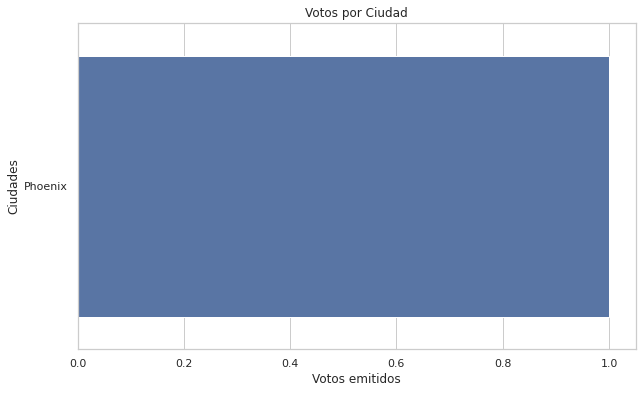

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
plt.ticklabel_format(useOffset=False, style="plain")
sns.set_theme(style="whitegrid")
sns.barplot(x="votos", y="city", data=pdVC).set_title("Votos por Ciudad")
plt.xlabel("Votos emitidos")
plt.ylabel("Ciudades")

plt.show()

Mas exactamente la salida para la dataset completa sería:  
![](https://community.cloud.databricks.com/files/Notebook_3/5.png)

O por ejemplo, si queremos unir dos gráficos:

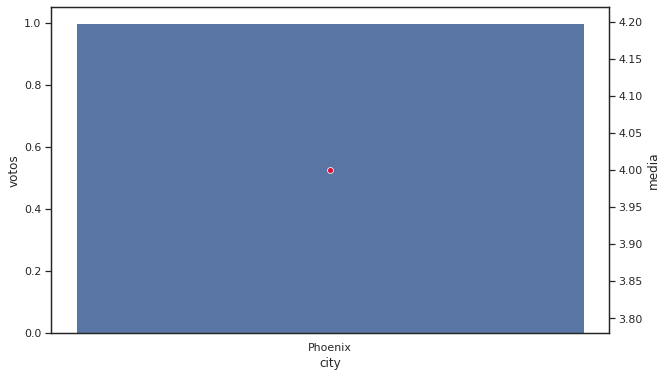

In [0]:
plt.figure(figsize=(10,6))
sns.set_theme(style="white")
ax = sns.barplot(data = pdVC, y="votos", x="city")

ax2 = ax.twinx()
sns.lineplot(data = pdVC['media'], marker='o', color='crimson', ax=ax2)
plt.show()

Mas exactamente la salida para la dataset completa sería:  
![](https://community.cloud.databricks.com/files/Notebook_3/6.png)

> **Out of Memory**  
> Mucho cuidado al utilizar Pandas, ya que al convertir el DataFrame nos vamos a traer todos los datos al driver, perdiendo la distribución de los datos y pudiendo provocar un error de falta de memoria.

Así pues, hay que evitar a toda costa utilizar Pandas para tratar los datos, ya que perdemos toda la potencia de trabajo en clúster (Pandas sólo puede utilizar los recursos del nodo principal). Únicamente lo utilizaremos cuando vayamos a visualizar los datos mediante Matplotlib / Seaborn como requisito de estas librerías.

> **Pandas y Koalas**  
> Desde la versión 3.2 de Spark, la librería de [Koalas](https://koalas.readthedocs.io/en/latest/) se ha integrado en Spark, dando lugar a poder utilizar el API de Pandas directamente desde Spark, lo que facilita el aprendizaje de Spark para aquellos desarrolladores que ya dominan Pandas. Para ello, únicamente hemos de importar la librería:  
`import pyspark.pandas as ps`  
Y acceder a `ps` de la misma manera que usamos `pd` al trabajar con Pandas.  
Un artículo muy interesante es [Run Pandas as Fast as Spark.](https://towardsdatascience.com/run-pandas-as-fast-as-spark-f5eefe780c45)

# Actividades

En las siguientes actividades vamos a realizar agregaciones mediante el uso del API de DataFrames de Spark.

1. Sobre las películas de la sesión anterior:  
  a. ¿Cuantas películas diferentes hay?  
  b. ¿En cuantas películas ha trabajado Murphy, Eddie (I)?  
  c. ¿Cuáles son los actores que han aparecido en más de 30 películas?  
  d. ¿En que película anterior a 1980 aparecen al menos 25 intérpretes?  
  e. Muestra la cantidad de películas producidas cada año (solo debe mostrar el año y la cantidad), ordenando el listado por la cantidad de forma descendente.  

2.  Nos han enviado un nuevo archivo llamado [movie-ratings.tsv](https://tajamar365.sharepoint.com/:u:/s/3405-MasterIA2024-2025/ESyjlCu2YQdGpqcMWiFTCp0BNJZaVLAXMurp-xVf_aUwsA?e=MxM7Bb) que contiene las calificaciones de las películas.  
  a. Crea un DataFrame que contenga los datos de ambos datasets.  
  b. Muestra para cada año, la película con mayor puntuación (año, título de la película, puntuación)  
  c. Sobre los datos anteriores, obtén también una lista con los nombres de los intérpretes.  
  d. Averigua las tres parejas de intérpretes han trabajado juntos en más ocasiones. La salida debe tener tres columnas: `interprete1`, `interprete2` y `cantidad`. (necesitas utilizar un *self-join*)

Las siguientes dos actividades se plantean como un proyecto a realizar en clase:  
3. Hemos recibido un dataset con las ventas de 2019 de una tienda americana de productos de tecnología, mediante un conjunto de ficheros en formato CSV comprimidos en [salesdata.zip](https://tajamar365.sharepoint.com/:u:/s/3405-MasterIA2024-2025/EVv159rps6hJqglAU4Afs4MB-xJI0Vkp-d86wBfBod1JGg?e=0R9Qj4).   
  a. Una vez descomprimidos los datos, crea un DataFrame con todos los datos, infiriendo el esquema.  
  b. Vuelve a realizar la lectura de los datos pero con el siguiente esquema:  
  ```<python>
  from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
esquema = StructType([
    StructField("Order ID", IntegerType(), False),
    StructField("Product", StringType(), False),
    StructField("Quantity Ordered", IntegerType(), True),
    StructField("Price Each", DoubleType(), False),
    StructField("Order Date", StringType(), False),
    StructField("Purchase Address", StringType(), False)
])
  ```

  c. Tras la lectura, vamos a realizar la limpieza de datos. El primer paso será renombrar la columnas para eliminar los espacios en blanco.  
  d. Elimina las filas que contengan algún campo nulo.  
  e. Comprueba si las cabeceras de los archivos aparecen como datos del dataset (por ejemplo, un producto cuyo nombre sea Product). Si fuera el caso, elimina dichas filas.  
  f. A partir del campo dirección, crea dos nuevas columnas para almacenar la ciudad (`City`) y el estado (`State`). Por ejemplo, para la dirección `136 Church St, New York City, NY 10001`, la ciudad es `New York City` y el estado es `NY`.  
  g. Modifica el campo con la fecha del pedido para que su formato sea *timestamp*.  
  h. Sobre el campo anterior, crea dos nuevas columnas, con el mes (`Month`) y el año (`Year`) del pedido.




4. Una vez realizada la transformación de los datos, vamos a realizar su carga y extraer información, utilizando Spark SQL siempre que sea posible:  
  a. Almacena los datos en formato *Parquet* en la carpeta `salesoutput` particionando los datos por año y mes. Tras ejecutar esta operación, comprueba en disco la estructura de archivos creada.  
  b. Sobre los datos almacenados, realiza una nueva lectura pero solo leyendo los datos de 2019 los cuales deberían estar almacenados en `./salesdataoutput/Year=2019`  
  c. Averigua cual ha sido el mes que ha recaudado más. Para ello, deberás multiplicar el precio por la cantidad de unidades, y posteriormente, realizar alguna agregación. Sobre el resultado, crea un gráfico (usando matplotlib y seaborn) similar al siguiente:  
  ![](https://community.cloud.databricks.com/files/Notebook_3/2.png)  
   

  d. Obtén un gráfico con las 10 ciudades que más unidades han vendido.  
  ![](https://community.cloud.databricks.com/files/Notebook_3/3.png) 

e. Cantidad de pedidos por Horas en las que se ha realizado un pedido que contenía al menos dos productos:  
![](https://community.cloud.databricks.com/files/Notebook_3/4.png) 


f. Listado con los productos del estado de NY que se han comprado a la vez, obteniendo un resultado similar a: 
``` 
+------------------------------------------------------------+-----+
|Productos                                                   |count|
+------------------------------------------------------------+-----+
|[iPhone, Lightning Charging Cable]                          |126  |
|[Google Phone, USB-C Charging Cable]                        |124  |
|[Google Phone, Wired Headphones]                            |52   |
...
```